In [1]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


car_images = glob.glob('training_data/vehicles/**/*.png')
notcar_images = glob.glob('training_data/non-vehicles/**/*.png')
print(len(car_images), len(notcar_images))

8792 8968


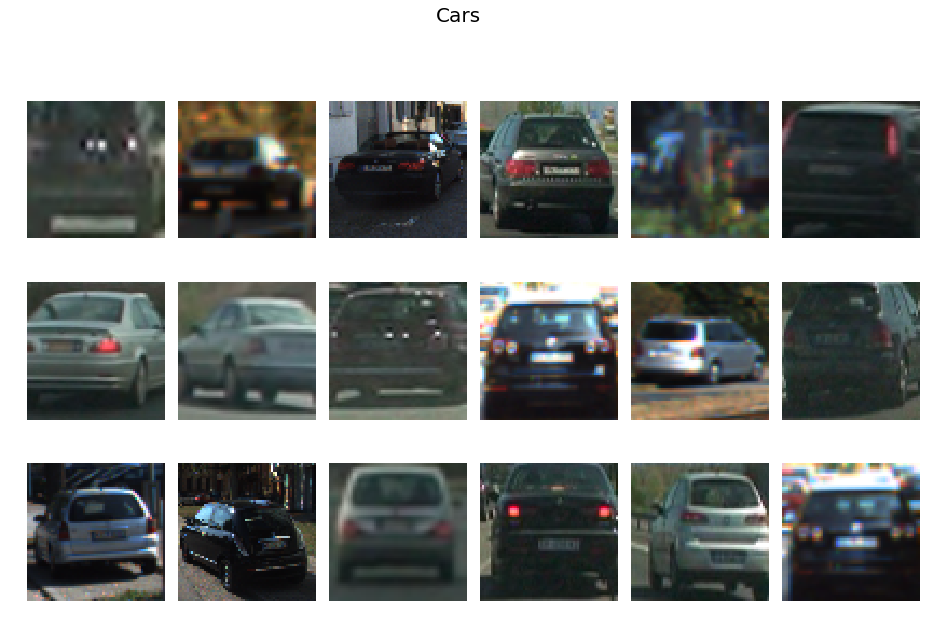

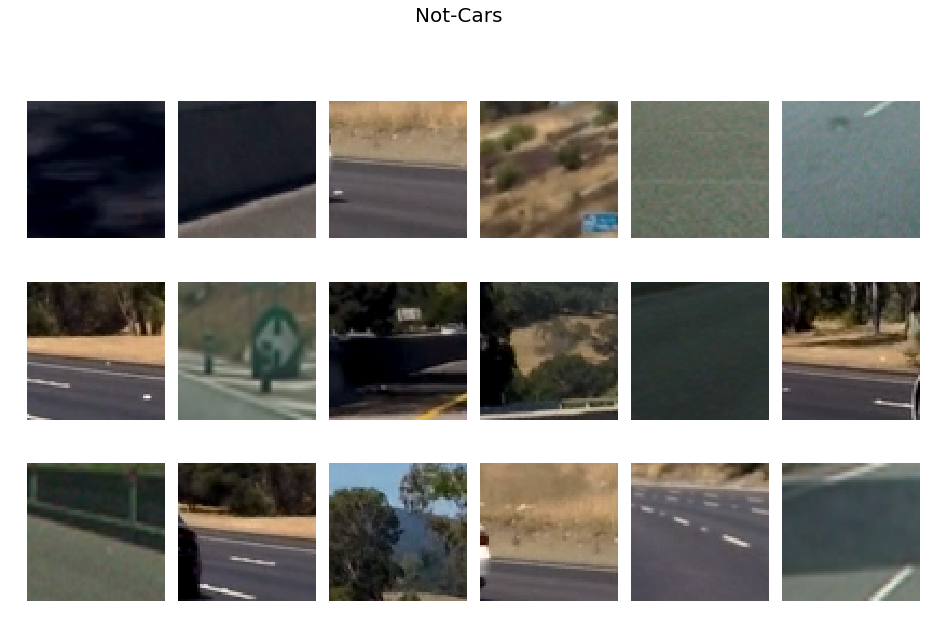

In [2]:
# Displaying sample images from two classes : Cars and Non-Cars

import cv2
import numpy as np

fig_cars, axs_cars = plt.subplots(3,6, figsize=(16, 10))
fig_cars.suptitle('Cars', fontsize=20)
fig_cars.subplots_adjust(hspace = 0.0001, wspace=.1)
axs_cars = axs_cars.ravel()

fig_ncars, axs_ncars = plt.subplots(3,6, figsize=(16, 10))
fig_ncars.suptitle('Not-Cars', fontsize=20)
fig_ncars.subplots_adjust(hspace = 0.0001, wspace=.1)
axs_ncars = axs_ncars.ravel()

for ax in axs_cars:
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax.axis('off')
    ax.imshow(img)

for ax in axs_ncars:
    img = cv2.imread(notcar_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax.axis('off')
    ax.imshow(img)

plt.show()

In [3]:
# Define a function to return HOG features of an image (from the lesson# 20)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

/Users/pkaul2/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


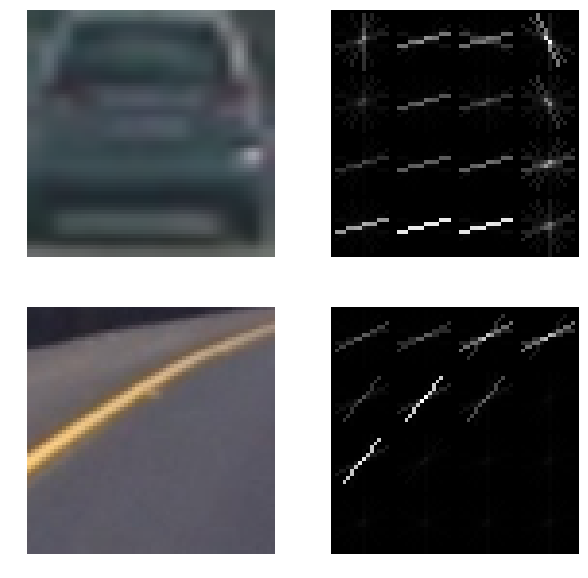

In [4]:
# Check the get_hog_features on sample images

# Read in the image
car_image = mpimg.imread(car_images[10])
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)

notcar_image = mpimg.imread(notcar_images[10])
notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 16
cell_per_block = 2

# Call our function with vis=True to see an image output
car_features, car_hog_image = get_hog_features(car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
notcar_features, notcar_hog_image = get_hog_features(notcar_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

car_array = [car_image, car_hog_image]
notcar_array = [notcar_image, notcar_hog_image]

# Plot the examples
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs = axs.ravel()

c=0
for i in car_array:
    axs[c].axis('off')
    axs[c].imshow(i, cmap='gray')
    c+=1

for i in notcar_array:
    axs[c].axis('off')
    axs[c].imshow(i, cmap='gray')
    c+=1
    

plt.show()

In [5]:
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [6]:
# Feature extraction

c_space = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

car_features = extract_features(car_images, cspace = c_space, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

notcar_features = extract_features(notcar_images, cspace=c_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)


X = np.vstack((car_features, notcar_features)).astype(np.float64)  
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


#rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)



/Users/pkaul2/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [7]:
svc = LinearSVC()
svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Test Accuracy of SVC =  0.9814


In [8]:
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, show_all_windows=False):
    
    boxes = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)
    
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]
        
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)  + 1
    nyblocks = (ch1.shape[0] // pix_per_cell)  + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL' :
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            xpos = xb*cells_per_step
            ypos = yb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            hog_features = hog_features.reshape(1, -1)
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_windows:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return boxes

In [10]:

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    new_color = (0, 0, 255)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        if color == 'random':
            new_color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        cv2.rectangle(imcopy, bbox[0], bbox[1], new_color, thick)
    # Return the image copy with boxes drawn
    return imcopy

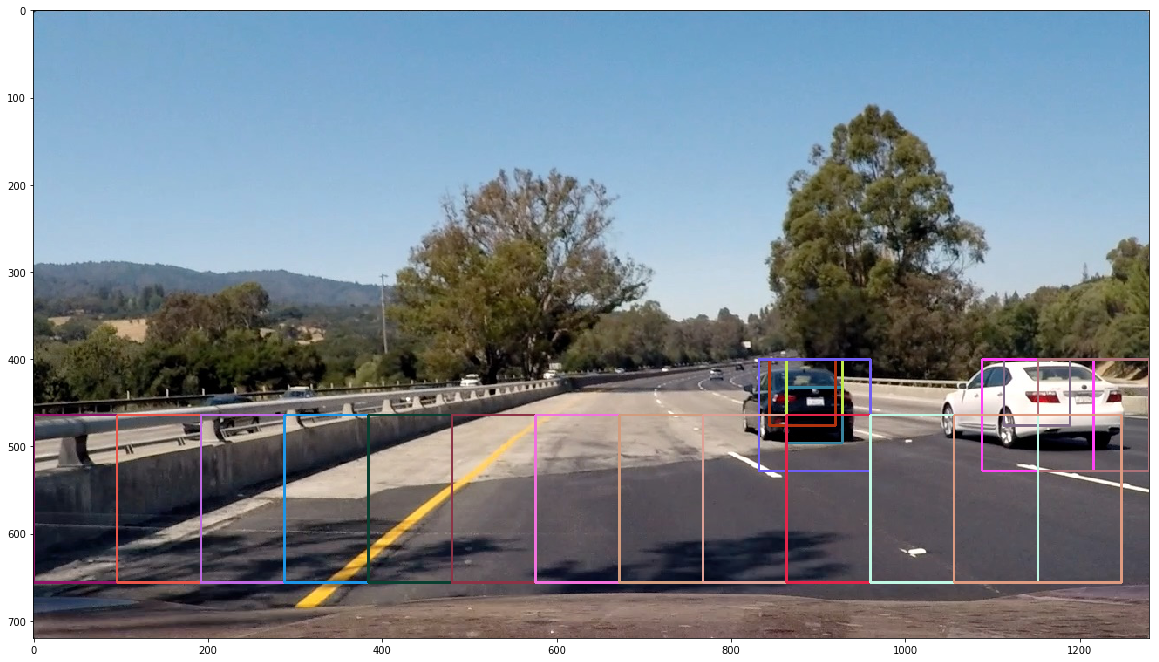

In [29]:
# Testing the ystart, ystop, scale values on all test_images <test1 ... 5>

test_img = mpimg.imread('./test_images/test4.jpg')

cspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

boxes = []

ystart = 400
ystop = 500
scale = 1.0
boxes.append(find_cars(test_img, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))

ystart = 416
ystop = 500
scale = 1.5
boxes.append(find_cars(test_img, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))


ystart = 400
ystop = 500
scale = 2
boxes.append(find_cars(test_img, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))

ystart = 400
ystop = 496
scale = 1
boxes.append(find_cars(test_img, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))


ystart = 432
ystop = 528
scale = 1.5
boxes.append(find_cars(test_img, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))

ystart = 400
ystop = 528
scale = 1.2
boxes.append(find_cars(test_img, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))


ystart = 400
ystop = 528
scale = 2.0
boxes.append(find_cars(test_img, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))


ystart = 432
ystop = 560
scale = 2.0
boxes.append(find_cars(test_img, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))
           
ystart = 400
ystop = 596
scale = 3
boxes.append(find_cars(test_img, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))


ystart = 464
ystop = 660
scale = 3
boxes.append(find_cars(test_img, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, True))


box_list = [item for sublist in boxes for item in sublist] 
test_img_with_boxes = draw_boxes(test_img, box_list, color='random', thick=2)
plt.figure(figsize=(20,20))
plt.imshow(test_img_with_boxes)

plt.show()

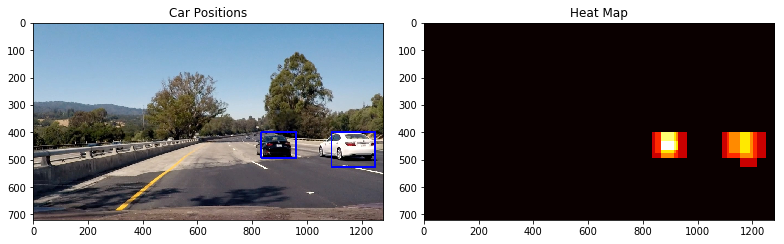

In [12]:
# Functions from lesson# 37 (Multiple detections and flase positives)

from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



# 'heating up' (pun intented!) test_img
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

# get heat image by adding heat to all the boxes identified
heat_image = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat_image = apply_threshold(heat,1)

heatmap = np.clip(heat, 0, 255)

labels = label(heatmap)

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)


fig = plt.figure(figsize=(11,11))

plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')

plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

plt.show()

In [33]:
# Defining a 'pipeline' to be tested on all test images and video frames. f ----> is the input image

def findCarsInFrame(f):
    box_list = []
    
    cspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.5
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))

    ystart = 432
    ystop = 498
    scale = 1.5
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))


    ystart = 400
    ystop = 496
    scale = 1.5
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))


    ystart = 432
    ystop = 528
    scale = 1.5
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))

    ystart = 400
    ystop = 528
    scale = 1.2
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))

    ystart = 400
    ystop = 528
    scale = 2.0
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))


    ystart = 432
    ystop = 560
    scale = 2.0
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))
           
    ystart = 400
    ystop = 596
    scale = 3
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))

    ystart = 464
    ystop = 660
    scale = 3
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))

    
    box_list = [item for sublist in box_list for item in sublist] 
    
    # 'heating up' (pun intented!) test_img
    heat = np.zeros_like(f[:,:,0]).astype(np.float)

    # get heat image by adding heat to all the boxes identified and return the heat image
    heat_image = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat_image = apply_threshold(heat,1)

    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)

    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(f), labels)
    return draw_img

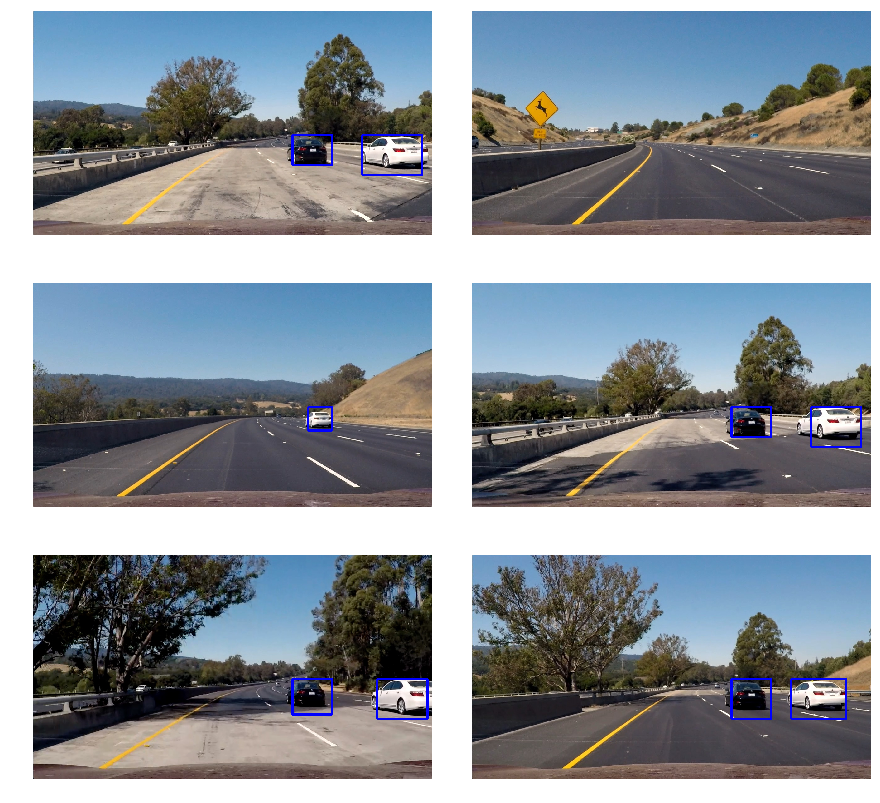

In [34]:
test_imgs = glob.glob('./test_images/test*.jpg')


fig, axs = plt.subplots(3, 2, figsize=(15,15))
fig.subplots_adjust(hspace = 0.0001, wspace=.1)
axs = axs.ravel()

c=0
for im in test_imgs:
    image = mpimg.imread(im)
    axs[c].axis("off")
    axs[c].imshow(findCarsInFrame(image))
    c=c+1
    
plt.show()

In [35]:
# Handling Video now

from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(findCarsInFrame)
%time clip_test_out.write_videofile('test_video_out.mp4', audio=False)


[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:10<00:00,  3.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 9.8 s, sys: 1.64 s, total: 11.4 s
Wall time: 11.7 s


In [36]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_out.mp4"))

In [95]:
# Defining a class to hold the boxes identified in the frames which are processed

class Box_list():
    def __init__(self):
        
        self.box_list = []
    
    def add_boxes(self, boxes):
        self.box_list.append(boxes)
        if len(self.box_list) > 20:
            # get rid of older sets
            self.box_list = self.box_list[-20:]

    

In [94]:
# Use the class above to store the 'boxes' found in each frame.
# We define a revised findCarsInFrame

def findCarsInVFrame(f):
    
    box_list = []
    
    cspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    
    
    ystart = 400
    ystop = 464
    scale = 1.0
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))

    ystart = 428
    ystop = 496
    scale = 1.5
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))

    
    ystart = 432
    ystop = 486
    scale = 1.5
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))

    ystart = 400
    ystop = 496
    scale = 1.5
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))
    
    ystart = 432
    ystop = 528
    scale = 1.5
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))

    ystart = 400
    ystop = 528
    scale = 2.0
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))
    
    ystart = 432
    ystop = 560
    scale = 2.0
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))
    
    ystart = 400
    ystop = 596
    scale = 3.5
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))
    
    ystart = 496
    ystop = 528
    scale = 2.0
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))
    

    ystart = 500
    ystop = 664
    scale = 3.0
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))
    
    ystart = 464
    ystop = 660
    scale = 3.5
    box_list.append(find_cars(f, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))
    
    
    box_list = [item for sublist in box_list for item in sublist] 
    
    # add detections to the history
    if len(box_list) > 0:
        det.add_boxes(box_list)
    
    
    # initialize a heat image to all zeros
    heat_image = np.zeros_like(f[:,:,0]).astype(np.float)
    
    #add heat to the heat_image at the pixels bound by boxes 
    for boxes in det.box_list:
        heat_image = add_heat(heat_image, boxes)
    
    # Apply threashold to the final heat_image (this time  the threashold is increased to the length of box_list)
    heat_image = apply_threshold(heat_image, 1+len(det.box_list)//1.4)
     
    labels = label(heat_image)
    
    draw_img = draw_labeled_bboxes(np.copy(f), labels)
    return draw_img

In [96]:
# initialize a fresh empty list for boxes
det = Box_list()


clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(findCarsInVFrame)
%time clip_test_out.write_videofile('test_video_out.mp4', audio=False)


[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4



 97%|█████████▋| 38/39 [00:11<00:00,  3.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 10.3 s, sys: 1.89 s, total: 12.2 s
Wall time: 12.3 s


In [97]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_out.mp4"))

In [98]:
# initialize a fresh empty list for boxes
det = Box_list()

project_clip = VideoFileClip('project_video.mp4')
project_clip_out = project_clip.fl_image(findCarsInVFrame)
%time project_clip_out.write_videofile('project_video_out.mp4', audio=False)


[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 12%|█▏        | 152/1261 [00:40<04:44,  3.89it/s]


 24%|██▍       | 303/1261 [01:19<04:09,  3.83it/s]


 36%|███▌      | 454/1261 [01:59<03:31,  3.82it/s]


 48%|████▊     | 605/1261 [02:39<02:50,  3.86it/s]


 60%|█████▉    | 756/1261 [03:19<02:15,  3.71it/s]


 72%|███████▏  | 907/1261 [03:59<01:33,  3.80it/s]


 84%|████████▍ | 1057/1261 [04:39<00:53,  3.80it/s]


 96%|█████████▌| 1205/1261 [05:18<00:14,  3.84it/s]


100%|█████████▉| 1260/1261 [05:33<00:00,  3.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 5min, sys: 51.3 s, total: 5min 51s
Wall time: 5min 33s


In [99]:
HTML("""
<video width="800" height="400" controls>
  <source src="{0}">
</video>
""".format('project_video_out.mp4'))